<a href="https://colab.research.google.com/github/KamilShape/twitter_sentiment_analysis/blob/main/twitter_sentiment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **1. Importing and validation data**

In [1]:
import re
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import string
import nltk
from nltk.tokenize import word_tokenize
import dask.dataframe as dd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, roc_auc_score

#### 1.1 Dataset description:

- 0 - the polarity of the tweet (0 = negative, 2 = neutral, 4 = positive)
- 1 - the id of the tweet (2087)
- 2 - the date of the tweet (Sat May 16 23:58:44 UTC 2009)
- 3 - the query (lyx). If there is no query, then this value is NO_QUERY.
- 4 - the user that tweeted (robotickilldozr)
- 5 - the text of the tweet (Lyx is cool)

In [2]:
COLUMNS = ['Polarity', 'ID', 'Date', 'Query', 'User_name', 'Text']
ENCODING = "ISO-8859-1"

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
tweets = pd.read_csv("/content/drive/MyDrive/twitter2.csv", encoding=ENCODING, names = COLUMNS )

In [5]:
tweets.head(10)

,Polarity,ID,Date,Query,User_name,Text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
5,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew
6,0,1467811592,Mon Apr 06 22:20:03 PDT 2009,NO_QUERY,mybirch,Need a hug
7,0,1467811594,Mon Apr 06 22:20:03 PDT 2009,NO_QUERY,coZZ,@LOLTrish hey long time no see! Yes.. Rains a...
8,0,1467811795,Mon Apr 06 22:20:05 PDT 2009,NO_QUERY,2Hood4Hollywood,@Tatiana_K nope they didn't have it
9,0,1467812025,Mon Apr 06 22:20:09 PDT 2009,NO_QUERY,mimismo,@twittera que me muera ?


In [6]:
len(tweets)

1600000

#### 1.2 Dataset info:

In [7]:
tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column     Non-Null Count    Dtype 
---  ------     --------------    ----- 
 0   Polarity   1600000 non-null  int64 
 1   ID         1600000 non-null  int64 
 2   Date       1600000 non-null  object
 3   Query      1600000 non-null  object
 4   User_name  1600000 non-null  object
 5   Text       1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


In [8]:
tweets.describe()

,Polarity,ID
count,1.600000e+06,1.600000e+06
mean,2.000000e+00,1.998818e+09
std,2.000001e+00,1.935761e+08
min,0.000000e+00,1.467810e+09
25%,0.000000e+00,1.956916e+09
50%,2.000000e+00,2.002102e+09
75%,4.000000e+00,2.177059e+09
max,4.000000e+00,2.329206e+09


#### 1.3 Checking null values:

In [9]:
np.sum(tweets.isnull().any(axis=1))

0

## **2. Data visualisation**

#### 2.1 Replacing positive value 4 to 1

In [10]:
tweets['Polarity'] = tweets['Polarity'].replace(4,1)

In [11]:
tweets['Polarity'].unique()

array([0, 1])

In [12]:
tweets_polarity = pd.DataFrame(tweets['Polarity'].value_counts()).reset_index()
tweets_polarity.columns = ['Polarity', 'Amount']

In [13]:
tweets_polarity

,Polarity,Amount
0,0,800000
1,1,800000


In [14]:
tweets_polarity['Polarity'].replace(0, 'Negative', inplace=True)

In [15]:
tweets_polarity['Polarity'].replace(1, 'Positive', inplace=True)

In [16]:
tweets_polarity

,Polarity,Amount
0,Negative,800000
1,Positive,800000


#### 2.2 Chart

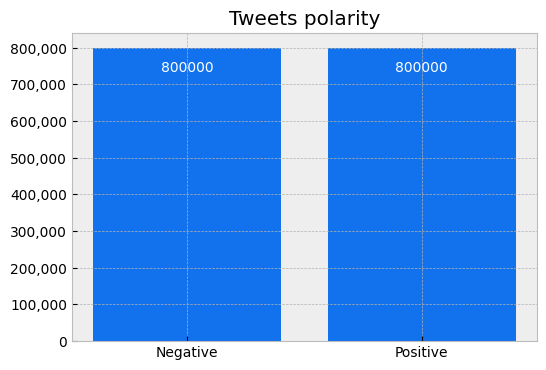

In [17]:
plt.style.use('bmh')
fig, ax=plt.subplots(figsize=(6,4))
ax.bar(tweets_polarity['Polarity'], tweets_polarity['Amount'], color='#1271ed')

ax.get_yaxis().set_major_formatter(
matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x)//1, ',')))
ax.set_title('Tweets polarity')

for i in range(0, len(tweets_polarity)):
  ax.text(tweets_polarity['Polarity'][i], tweets_polarity['Amount'][i]-65000, tweets_polarity['Amount'][i],
          horizontalalignment='center', color='w')

## **3. Data preprocessing**

#### **3.1 Selected columns**

In [18]:
tweets_data = tweets[['Polarity', 'Text']]

In [19]:
tweets_data.head(10)

,Polarity,Text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."
5,0,@Kwesidei not the whole crew
6,0,Need a hug
7,0,@LOLTrish hey long time no see! Yes.. Rains a...
8,0,@Tatiana_K nope they didn't have it
9,0,@twittera que me muera ?


#### 3.2 Making tweets text to lowercase

In [20]:
tweets_data['Text'] = tweets_data['Text'].str.lower()

<ipython-input-20-d870b1e4c535>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tweets_data['Text'] = tweets_data['Text'].str.lower()


In [21]:
tweets_data.head(10)

,Polarity,Text
0,0,"@switchfoot http://twitpic.com/2y1zl - awww, t..."
1,0,is upset that he can't update his facebook by ...
2,0,@kenichan i dived many times for the ball. man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."
5,0,@kwesidei not the whole crew
6,0,need a hug
7,0,@loltrish hey long time no see! yes.. rains a...
8,0,@tatiana_k nope they didn't have it
9,0,@twittera que me muera ?


#### **3.3 Removing punctuations**

In [22]:
punctuation_list = string.punctuation

In [23]:
def remove_punctuation(text):
    return text.translate(str.maketrans('', '', punctuation_list))  

In [24]:
tweets_data['Text'] = tweets_data['Text'].apply(lambda x: remove_punctuation(x))

<ipython-input-24-bde98e0cf2ff>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tweets_data['Text'] = tweets_data['Text'].apply(lambda x: remove_punctuation(x))


#### 3.4 Removing stopwords

In [26]:
stopwords = ['a', 'about', 'above', 'after', 'again', 'ain', 'all', 'am', 'an',
             'and','any','are', 'as', 'at', 'be', 'because', 'been', 'before',
             'being', 'below', 'between','both', 'by', 'can', 'd', 'did', 'do',
             'does', 'doing', 'down', 'during', 'each','few', 'for', 'from',
             'further', 'had', 'has', 'have', 'having', 'he', 'her', 'here',
             'hers', 'herself', 'him', 'himself', 'his', 'how', 'i', 'if', 'in',
             'into','is', 'it', 'its', 'itself', 'just', 'll', 'm', 'ma',
             'me', 'more', 'most','my', 'myself', 'now', 'o', 'of', 'on', 'once',
             'only', 'or', 'other', 'our', 'ours','ourselves', 'out', 'own', 're','s', 
             'same', 'she', "shes", 'should', "shouldve",'so', 'some', 'such',
             't', 'than', 'that', "thatll", 'the', 'their', 'theirs', 'them',
             'themselves', 'then', 'there', 'these', 'they', 'this', 'those',
             'through', 'to', 'too','under', 'until', 'up', 've', 'very', 'was',
             'we', 'were', 'what', 'when', 'where','which','while', 'who', 'whom',
             'why', 'will', 'with', 'won', 'y', 'you', "youd","youll", "youre",
             "youve", 'your', 'yours', 'yourself', 'yourselves']

In [27]:
def delete_stopwords(txt):
    text = txt.split(" ")
    formated_text = [word for word in text if word not in stopwords]
    return " ".join(formated_text)

In [28]:
tweets_data['Text'] = tweets_data['Text'].apply(lambda x: delete_stopwords(x))

<ipython-input-28-baabe6ef86bb>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tweets_data['Text'] = tweets_data['Text'].apply(lambda x: delete_stopwords(x))


#### 3.5 Removing numbers

In [30]:
def remove_number(text):
    return re.sub('[0-9]+', '', text)

In [31]:
tweets_data['Text'] = tweets_data['Text'].apply(lambda x: remove_number(x))

<ipython-input-31-fa69f787bda1>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tweets_data['Text'] = tweets_data['Text'].apply(lambda x: remove_number(x))


Dask library is used in 3.6, 3.7 and 3.8 because of database is almost 230MB and participation makes colab work much faster.

#### 3.6 Tweets tokenization

In [34]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [35]:
tweets_data_dask = dd.from_pandas(tweets_data, npartitions=5)

In [36]:
tweets_data_dask = dd.from_pandas(tweets_data, npartitions=5)
tweets_data_dask['Text'] = tweets_data_dask['Text'].apply(lambda x: word_tokenize(x, language='english'))

/usr/local/lib/python3.10/dist-packages/dask/dataframe/core.py:4134: UserWarning: 
You did not provide metadata, so Dask is running your function on a small dataset to guess output types. It is possible that Dask will guess incorrectly.
To provide an explicit output types or to silence this message, please provide the `meta=` keyword, as described in the map or apply function that you are using.
  Before: .apply(func)
  After:  .apply(func, meta=('Text', 'object'))

  warnings.warn(meta_warning(meta))


#### 3.7 Stemming

In [37]:
st = nltk.PorterStemmer()
def stemming_on_text(text):
    text = [st.stem(word) for word in text]
    return " ".join(text)

tweets_data_dask['Text']= tweets_data_dask['Text'].apply(lambda x: stemming_on_text(x))

/usr/local/lib/python3.10/dist-packages/dask/dataframe/core.py:4134: UserWarning: 
You did not provide metadata, so Dask is running your function on a small dataset to guess output types. It is possible that Dask will guess incorrectly.
To provide an explicit output types or to silence this message, please provide the `meta=` keyword, as described in the map or apply function that you are using.
  Before: .apply(func)
  After:  .apply(func, meta=('Text', 'object'))

  warnings.warn(meta_warning(meta))


#### 3.8 Lemmatization

In [39]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [40]:
lm = nltk.WordNetLemmatizer()
def lemmatizer_on_text(text):
    text = [lm.lemmatize(word) for word in text]
    return " ".join(text)
tweets_data_dask['Text'] = tweets_data_dask['Text'].apply(lambda x: lm.lemmatize(x))

/usr/local/lib/python3.10/dist-packages/dask/dataframe/core.py:4134: UserWarning: 
You did not provide metadata, so Dask is running your function on a small dataset to guess output types. It is possible that Dask will guess incorrectly.
To provide an explicit output types or to silence this message, please provide the `meta=` keyword, as described in the map or apply function that you are using.
  Before: .apply(func)
  After:  .apply(func, meta=('Text', 'object'))

  warnings.warn(meta_warning(meta))


In [41]:
tweets_data = tweets_data_dask.compute()

In [42]:
tweets_data.head(10)

,Polarity,Text
0,0,switchfoot httptwitpiccomyzl awww that bummer ...
1,0,upset cant updat facebook text might cri resul...
2,0,kenichan dive mani time ball manag save rest g...
3,0,whole bodi feel itchi like fire
4,0,nationwideclass no not behav im mad cant see over
5,0,kwesidei not whole crew
6,0,need hug
7,0,loltrish hey long time no see ye rain bit bit ...
8,0,tatianak nope didnt
9,0,twittera que muera


## 4. Train and test split

In [65]:
X = tweets_data['Text']
y = tweets_data['Polarity']

In [66]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.1, random_state = 42)

In [67]:
X_train

1205857                                saw pictur heart melt
20363                         ethanonli uni exam period asot
902802                                  jammin capit gard xx
223111     talk mike skype greatest thing ever ohio far away
12577      gosh dont hate guy damn perfect but never go u...
                                 ...                        
259178             song middl chang doesnt want born arghhhh
1414414                              officialnjona good luck
131932                         proudgamertweet rather averag
671155     pickin misstinayao waitin sadittysash hurri up...
121958                 home studi math wooot im go fail shit
Name: Text, Length: 1440000, dtype: object

## 5. TF-IDF Vectorizer

In [68]:
vectoriser = TfidfVectorizer(max_features=100000)
vectoriser.fit(X_train)

TfidfVectorizer(max_features=100000)

In [47]:
X_train = vectoriser.fit_transform(X_train)
X_test  = vectoriser.transform(X_test)

## 6. Classification models

#### 6.1 Naive Bayes Classifier

In [48]:
BNBmodel = BernoulliNB()
BNBmodel.fit(X_train, y_train)
y_pred_nb = BNBmodel.predict(X_test)

In [49]:
print(classification_report(y_test, y_pred_nb))

              precision    recall  f1-score   support

           0       0.78      0.78      0.78     79812
           1       0.78      0.77      0.78     80188

    accuracy                           0.78    160000
   macro avg       0.78      0.78      0.78    160000
weighted avg       0.78      0.78      0.78    160000



<Axes: >

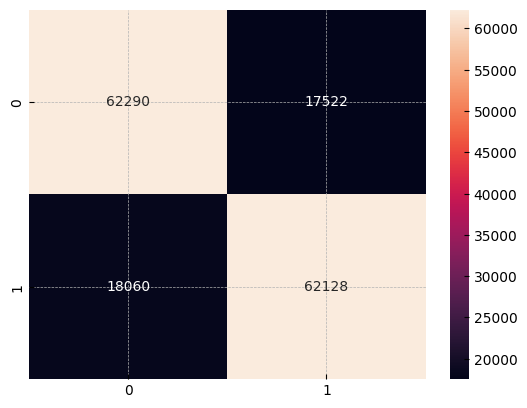

In [50]:
cm = confusion_matrix(y_test, y_pred_nb)
sns.heatmap(cm, annot = True, fmt=".0f")

#### 6.2 Linear SVC 

In [51]:
SVCmodel = LinearSVC()
SVCmodel.fit(X_train, y_train)
y_pred_svc = SVCmodel.predict(X_test)

In [52]:
print(classification_report(y_test, y_pred_svc))

              precision    recall  f1-score   support

           0       0.79      0.77      0.78     79812
           1       0.78      0.80      0.79     80188

    accuracy                           0.79    160000
   macro avg       0.79      0.79      0.79    160000
weighted avg       0.79      0.79      0.79    160000



<Axes: >

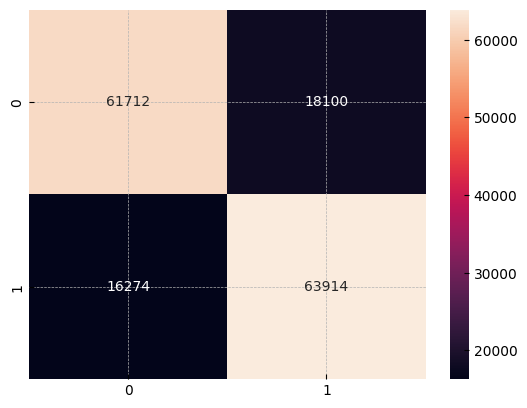

In [53]:
cm = confusion_matrix(y_test, y_pred_svc)
sns.heatmap(cm, annot = True, fmt=".0f")

#### 6.3 Logistic Regresion 

In [54]:
LRmodel = LogisticRegression(max_iter = 1000)
LRmodel.fit(X_train, y_train)
y_pred_lr = LRmodel.predict(X_test)

In [56]:
print(classification_report(y_test, y_pred_lr))

              precision    recall  f1-score   support

           0       0.80      0.78      0.79     79812
           1       0.78      0.81      0.79     80188

    accuracy                           0.79    160000
   macro avg       0.79      0.79      0.79    160000
weighted avg       0.79      0.79      0.79    160000



<Axes: >

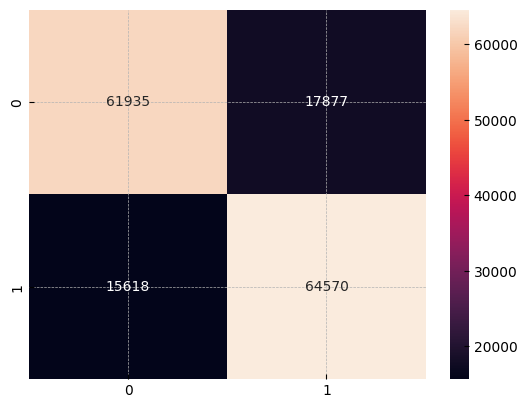

In [57]:
cm = confusion_matrix(y_test, y_pred_lr)
sns.heatmap(cm, annot = True, fmt=".0f")

## 7. ROC Curves

In [62]:
help_prob=[0 for _ in range(len(y_test))]
nb_tpr, nb_fpr, _ = roc_curve(y_test, y_pred_nb)
svc_tpr, svc_fpr, _ = roc_curve(y_test, y_pred_svc)
lr_tpr, lr_fpr, _ = roc_curve(y_test, y_pred_lr)
help_tpr, help_fpr, _ = roc_curve(y_test, help_prob)
print(nb_tpr, nb_fpr, _ )


[0.         0.21954092 1.        ] [0.         0.77477927 1.        ] [1 0]


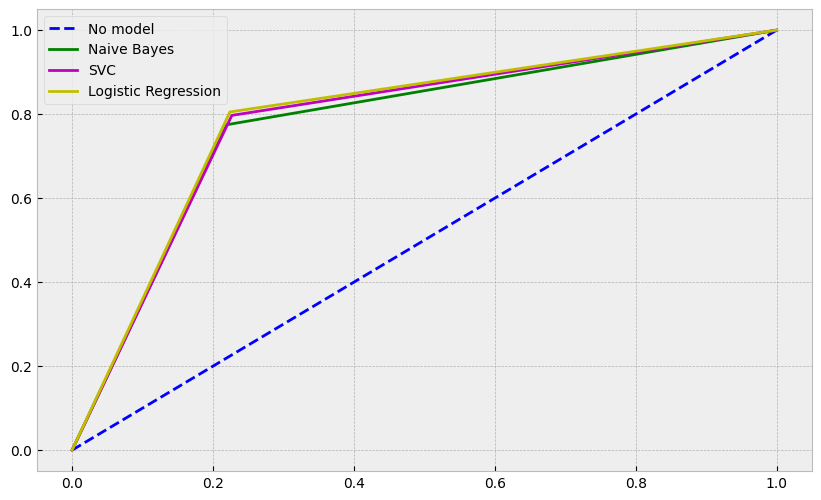

In [64]:
fig, ax = plt.subplots(figsize = (10,6))
ax.plot(help_tpr, help_fpr, label = 'No model', color='b', linestyle='--')
ax.plot(nb_tpr, nb_fpr, label = 'Naive Bayes', color='g')
ax.plot(svc_tpr, svc_fpr, label = 'SVC', color = 'm' )
ax.plot(lr_tpr, lr_fpr, label = 'Logistic Regression', color = 'y')
ax.legend()